## Imports

In [13]:
import json
import os
import time
from datetime import datetime

import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import requests
import seaborn as sns

In [14]:
sns.set(
    font="Franklin Gothic Book",
    rc={
        "axes.axisbelow": False,
        "axes.edgecolor": "lightgrey",
        "axes.facecolor": "None",
        "axes.grid": False,
        "axes.labelcolor": "dimgrey",
        "axes.spines.right": False,
        "axes.spines.top": False,
        "figure.facecolor": "white",
        "lines.solid_capstyle": "round",
        "patch.edgecolor": "w",
        "patch.force_edgecolor": True,
        "text.color": "dimgrey",
        "xtick.bottom": False,
        "xtick.color": "dimgrey",
        "xtick.direction": "out",
        "xtick.top": False,
        "ytick.color": "dimgrey",
        "ytick.direction": "out",
        "ytick.left": False,
        "ytick.right": False,
    },
)
sns.set_context(
    "notebook", rc={"font.size": 16, "axes.titlesize": 20, "axes.labelsize": 18}
)

colors = ["#073b4c", "#ffd166", "#06d6a0", "#118ab2", "#ef476f", "#fb5607"]
patterns = ["/", "\\", "-", "+", "x", "o", "O", ".", "*", "|"]
markers = ["o", "s", "D", "^", "v", "*", "X", "+", "p", "h"]

## Find where posters are shared

### Look at Datacite's poster related DOI

In [15]:
# get all poster related metadata from datacite
dict_results = {}
count = 0
next_page = True
get_link = "https://api.datacite.org/dois?query=types.resourceType:Poster&page[cursor]=1&page[size]=1000"

while next_page:
    r = json.loads(requests.get(get_link).content)
    for result in r["data"]:
        dict_results[count] = result
        count += 1
    if "next" in r["links"].keys():
        get_link = r["links"]["next"]
    else:
        next_page = False

with open("outputs/datacite.json", "w", encoding="utf-8") as f:
    json.dump(dict_results, f, ensure_ascii=False, indent=4)

In [17]:
# load data
with open("outputs/datacite.json", "r", encoding="utf-8") as file:
    results = json.load(file)

In [ ]:
# get a list of repositories with relevant info

    # name of repo 

    # url of repo

    # total number of poster published 

    # earliest year poster published

    # latest year poster published

    # doi of one poster (to have a link)







### Search on Google

## Get data from repositories

### Get posters metadata from Zenodo

In [3]:
# token
zenodo_access_token = os.getenv("ZENODO_ACCESS_TOKEN")

In [12]:
# Zenodo doesn't return more than 10k results per request so need to break down into date ranges with less than 10k posters created each
date_range_list = [
    "{* TO 2020-12-31]",
    "[2021-01-01 TO 2022-12-31]",
    "[2023-01-01 TO 2024-12-31]",
]

dict_results = {}
count = 0
for date_range in date_range_list:

    increment_page = True
    page = 0

    while increment_page:
        page += 1
        params = {
            "resource_type": "poster",
            "q": "created:" + date_range,
            "status": "published",
            "sort": "mostrecent",
            "all_versions": "false",
            "size": 300,
            "page": page,
            "access_token": zenodo_access_token,
        }
        response = requests.get(
            "https://zenodo.org/api/records",
            params=params,
        )

        if response.status_code == 200:
            r = response.json()
            if r["hits"]["hits"]:

                results = r["hits"]["hits"]

                for result in results:
                    dict_results[count] = result
                    count += 1
            else:
                print("No more pages", response.status_code, str(page))
                increment_page = False

        else:
            print("Error", response.status_code, response.content, str(page))
            increment_page = False

with open("outputs/zenodo.json", "w", encoding="utf-8") as f:
    json.dump(dict_results, f, ensure_ascii=False, indent=4)

No more pages 200 26
No more pages 200 27
No more pages 200 34


#### Notes:  
- Role of researchers are not shown on the online record or the api record: why ask it?
- Additional dates: The dates are shown in the online record but not included in the api record, why?
- publication_date: provided by user
- creation_date: date when the record was created (since we are only looking at the latest version, this is the creation date of the latest version)

### Get posters metadata from Figshare

In [6]:
# token
figshare_access_token = os.getenv("FIGSHARE_ACCESS_TOKEN")

In [7]:
# Inspired from the example available here https://help.figshare.com/article/how-to-use-the-figshare-api#search-ids
# get info of all the posters (unlike Zenodo, this doesn't return all the metadata for each poster
# so we do that only to get all the ids of the posters)
BASE_URL = "https://api.figshare.com/v2"
results = []

posted_after_list = ["2012-02-26", "2021-01-01"]
posted_before_list = ["2020-12-31", "2024-12-31"]

for posted_after, posted_before in zip(posted_after_list, posted_before_list):
    search_logic = (
        ":item_type:poster AND "
        + ":posted_after:"
        + posted_after
        + " AND :posted_before:"
        + posted_before
    )
    query = '{"search_for": "' + search_logic + '"}'
    y = json.loads(query)

    for j in range(1, 11):
        r = json.loads(
            requests.post(
                BASE_URL + "/articles/search?page_size=1000&page={}".format(j), params=y
            ).content
        )
        if r:
            results.extend(r)
        else:
            break

In [8]:
# use figshare ids to get full metadata of each poster
dict_results = {}
count = 0
for result in results:
    if isinstance(result, dict):
        figshare_id = result["id"]
        api_call_headers = {"Authorization": "token " + str(figshare_access_token)}
        r = requests.get(
            BASE_URL + "/articles/" + str(figshare_id), headers=api_call_headers
        )
        metadata = json.loads(r.text)
        dict_results[count] = metadata
        count += 1

with open("outputs/figshare.json", "w", encoding="utf-8") as f:
    json.dump(dict_results, f, ensure_ascii=False, indent=4)

### F1000Research

F1000 Research doesn't have an API for their posters (we reached out to them to get confirmation). There we just manually got the number of posters published each year using their poster filter at https://f1000research.com/browse/posters and added them to the f1000research.csv file

## Data processing

Transform the json data from the repositories and Datacite into a common tabular format to faciliate analysis

### Datacite

### Zenodo

In [18]:
# load data
with open("outputs/zenodo.json", "r", encoding="utf-8") as file:
    results = json.load(file)

In [19]:
# zenodo record schema https://github.com/zenodo/zenodo/blob/master/zenodo/modules/records/jsonschemas/records/record-v1.0.0.json                                                                                                                                                                         if metadata["access_right"] == "open":
rows_list = []

for result in results.values():
    row_dict = {}
    metadata = result["metadata"]

    # id and links
    row_dict["doi"] = False
    if "doi" in result.keys():
        row_dict["doi"] = result["doi"]
    row_dict["doi_url"] = False
    if "doi_url" in result.keys():
        row_dict["doi_url"] = result["doi_url"]
    row_dict["repository_url"] = False
    if "links" in result.keys():
        if "self_html" in result["links"].keys():
            row_dict["repository_url"] = result["links"]["self_html"]

    # access right
    row_dict["is_open_access"] = False
    if "access_right" in metadata.keys():
        if metadata["access_right"] == "open":
            row_dict["is_open_access"] = True

    # authors
    authors_count = 0
    authors_affiliation_count = 0
    authors_familyname_count = 0
    authors_givennames_count = 0
    authors_gnd_count = 0
    authors_name_count = 0
    authors_orcid_count = 0
    if "creators" in metadata.keys():
        authors_list = metadata["creators"]
        authors_count = len(authors_list)
        for author in authors_list:
            if "affiliation" in author.keys():
                if author["affiliation"] != None:
                    if len(author["affiliation"].strip()) > 0:
                        authors_affiliation_count += 1
            if "familyname" in author.keys():
                if len(author["familyname"].strip()) > 0:
                    authors_familyname_count += 1
            if "givennames" in author.keys():
                if len(author["givennames"].strip()) > 0:
                    authors_givennames_count += 1
            if "gnd" in author.keys():
                if len(author["gnd"].strip()) > 0:
                    authors_gnd_count += 1
            if "name" in author.keys():
                if len(author["name"].strip()) > 0:
                    authors_name_count += 1
            if "orcid" in author.keys():
                if len(author["orcid"].strip()) > 0:
                    authors_orcid_count += 1

    row_dict["authors_count"] = authors_count
    row_dict["authors_affiliation_count"] = authors_affiliation_count
    row_dict["authors_familyname_count"] = authors_familyname_count
    row_dict["authors_givennames_count"] = authors_givennames_count
    row_dict["authors_gnd_count"] = authors_gnd_count
    row_dict["authors_name_count"] = authors_name_count
    row_dict["authors_orcid_count"] = authors_orcid_count

    # grants
    row_dict["has_funding_info"] = False
    if "grants" in metadata.keys():
        if len(metadata["grants"]) > 0:
            row_dict["has_funding_info"] = True

    # journal
    row_dict["has_journal"] = False
    if "journal" in metadata.keys():
        if len(metadata["journal"]) > 0:
            row_dict["has_journal"] = True

    # keywords free text
    row_dict["keywords_freetext_count"] = 0
    if "references" in metadata.keys():
        if len(metadata["references"]) > 0:
            row_dict["keywords_freetext_count"] = len(metadata["references"])

    # keywords controlled vocabularies
    row_dict["keywords_controlled_vocabularies_count"] = 0
    if "related_identifiers" in metadata.keys():
        if len(metadata["related_identifiers"]) > 0:
            row_dict["keywords_controlled_vocabularies_count"] = len(
                metadata["related_identifiers"]
            )

    # language
    row_dict["has_language"] = False
    if "language" in metadata.keys():
        if len(metadata["language"]) > 0:
            row_dict["has_language"] = True

    # license
    row_dict["has_license"] = False
    row_dict["license_name"] = "NA"
    if "license" in metadata.keys():
        row_dict["has_license"] = True
        row_dict["license_name"] = metadata["license"]["id"]

    # conference
    row_dict["has_conference_acronym"] = False
    row_dict["has_conference_dates"] = False
    row_dict["has_conference_place"] = False
    row_dict["has_conference_session"] = False
    row_dict["has_conference_session_part"] = False
    row_dict["has_conference_title"] = False
    row_dict["has_conference_website"] = False
    if "meeting" in metadata.keys():
        conference_metadata = metadata["meeting"]

        if "acronym" in conference_metadata.keys():
            if len(conference_metadata["acronym"].strip()) > 0:
                row_dict["has_conference_acronym"] = True

        if "dates" in conference_metadata.keys():
            if len(conference_metadata["dates"].strip()) > 0:
                row_dict["has_conference_dates"] = True

        if "place" in conference_metadata.keys():
            if len(conference_metadata["place"].strip()) > 0:
                row_dict["has_conference_place"] = True

        if "session" in conference_metadata.keys():
            if len(conference_metadata["session"].strip()) > 0:
                row_dict["has_conference_session"] = True

        if "session_part" in conference_metadata.keys():
            if len(conference_metadata["session_part"].strip()) > 0:
                row_dict["has_conference_session_part"] = True

        if "title" in conference_metadata.keys():
            if len(conference_metadata["title"].strip()) > 0:
                row_dict["has_conference_title"] = True

        if "url" in conference_metadata.keys():
            if len(conference_metadata["url"].strip()) > 0:
                row_dict["has_conference_website"] = True

    # creation_date
    row_dict["has_creation_date"] = False
    row_dict["creation_date"] = "NA"
    if "created" in result.keys():
        if len(result["created"].strip()) > 0:
            row_dict["has_creation_date"] = True
            row_dict["creation_date"] = result["created"]

    # other dates:
    row_dict["has_other_dates"] = False
    row_dict["other_dates"] = "NA"
    if "dates" in metadata.keys():
        if len(metadata["dates"]) > 0:
            row_dict["has_other_dates"] = True
            dates_count = 0
            dates_info = ""
            for date in metadata["dates"]:
                if dates_count > 0:
                    dates_info += "; "
                dates_info += str(date)
                files_count += 1
            row_dict["other_dates"] = dates_info

    # references
    row_dict["references_no_identifiers_count"] = 0
    if "references" in metadata.keys():
        if len(metadata["references"]) > 0:
            row_dict["references_no_identifiers_count"] = len(metadata["references"])

    # related identifiers count
    row_dict["references_with_identifiers_count"] = 0
    if "related_identifiers" in metadata.keys():
        if len(metadata["related_identifiers"]) > 0:
            row_dict["references_with_identifiers_count"] = len(
                metadata["related_identifiers"]
            )

    # title
    row_dict["has_title"] = False
    if "title" in metadata.keys():
        if len(metadata["title"].strip()) > 0:
            row_dict["has_title"] = True

    # version
    row_dict["has_version"] = False
    if "version" in metadata.keys():
        if len(metadata["version"].strip()) > 0:
            row_dict["has_version"] = True

    # files
    files = result["files"]
    files_names = ""
    files_count = 0
    for file in files:
        if files_count > 0:
            files_names += "; "
        files_names += str(file["key"])
        files_count += 1
    row_dict["files"] = files_names

    # add to list
    rows_list.append(row_dict)

# save
df = pd.DataFrame(rows_list)
df.to_csv("outputs/zenodo.csv", index=False)

### Figshare

In [20]:
# load data
with open("outputs/figshare.json", "r", encoding="utf-8") as file:
    results = json.load(file)

In [21]:
rows_list = []
for metadata in results.values():
    row_dict = {}

    # id and links
    row_dict["doi"] = False
    row_dict["doi_url"] = False
    if "doi" in metadata.keys():
        row_dict["doi"] = metadata["doi"]
        row_dict["doi_url"] = "https://doi.org/" + metadata["doi"]
    row_dict["repository_url"] = False
    if "url_public_html" in metadata.keys():
        row_dict["repository_url"] = metadata["url_public_html"]

    # access right
    row_dict["is_open_access"] = False
    if "is_public" in metadata.keys():
        if metadata["is_public"]:
            row_dict["is_open_access"] = True

    # authors
    authors_count = 0
    authors_affiliation_count = -1
    authors_familyname_count = -1
    authors_givennames_count = -1
    authors_gnd_count = -1
    authors_name_count = 0
    authors_orcid_count = 0
    if "authors" in metadata.keys():
        authors_list = metadata["authors"]
        authors_count = len(authors_list)
        for author in authors_list:
            if "full_name" in author.keys():
                if len(author["full_name"].strip()) > 0:
                    authors_name_count += 1
            if "orcid_id" in author.keys():
                if len(author["orcid_id"].strip()) > 0:
                    authors_orcid_count += 1

    row_dict["authors_count"] = authors_count
    row_dict["authors_affiliation_count"] = authors_affiliation_count
    row_dict["authors_familyname_count"] = authors_familyname_count
    row_dict["authors_givennames_count"] = authors_givennames_count
    row_dict["authors_gnd_count"] = authors_gnd_count
    row_dict["authors_name_count"] = authors_name_count
    row_dict["authors_orcid_count"] = authors_orcid_count

    # grants
    row_dict["has_funding_info"] = False
    if "funding_list" in metadata.keys():
        if len(metadata["funding_list"]) > 0:
            row_dict["has_funding_info"] = True

    # journal
    row_dict["has_journal"] = "Not supported"

    # keywords free text
    row_dict["keywords_freetext_count"] = 0
    if "tags" in metadata.keys():
        if len(metadata["tags"]) > 0:
            row_dict["keywords_freetext_count"] = len(metadata["tags"])

    # keywords controlled vocabularies
    row_dict["keywords_controlled_vocabularies_count"] = -1

    # language
    row_dict["has_language"] = "Not supported"

    # license
    row_dict["has_license"] = False
    row_dict["license_name"] = "NA"
    if "license" in metadata.keys():
        row_dict["has_license"] = True
        row_dict["license_name"] = metadata["license"]["name"]

    # conference
    row_dict["has_conference_acronym"] = "Not supported"
    row_dict["has_conference_dates"] = "Not supported"
    row_dict["has_conference_place"] = "Not supported"
    row_dict["has_conference_session"] = "Not supported"
    row_dict["has_conference_session_part"] = "Not supported"
    row_dict["has_conference_title"] = "Not supported"
    row_dict["has_conference_website"] = "Not supported"

    # creation date
    row_dict["has_creation_date"] = False
    row_dict["creation_date"] = "NA"
    if "published_date" in metadata.keys():
        if len(metadata["published_date"].strip()) > 0:
            row_dict["has_creation_date"] = True
            row_dict["creation_date"] = metadata["published_date"]

    # other dates
    row_dict["has_other_dates"] = "Not supported"
    row_dict["other_dates"] = "NA"

    # references with no identifiers count
    row_dict["references_no_identifiers_count"] = -1

    # references with identifiers count
    row_dict["references_with_identifiers_count"] = 0
    if "related_materials" in metadata.keys():
        if len(metadata["related_materials"]) > 0:
            row_dict["references_with_identifiers_count"] = len(
                metadata["related_materials"]
            )

    # title
    row_dict["has_title"] = False
    if "title" in metadata.keys():
        if len(metadata["title"].strip()) > 0:
            row_dict["has_title"] = True

    # version
    row_dict["has_version"] = False
    if "version" in metadata.keys():
        row_dict["has_version"] = True

    # files
    if "files" in metadata.keys():
        files = metadata["files"]
        files_names = ""
        files_count = 0
        for file in files:
            if files_count > 0:
                files_names += "; "
            files_names += str(file["name"])
            files_count += 1
        row_dict["files"] = files_names

    # save
    rows_list.append(row_dict)

# save
df = pd.DataFrame(rows_list)
df.to_csv("outputs/figshare.csv", index=False)

## Analysis of poster publications per year

## Analysis of Datacite metadata

## Analysis of repositories metadata

### Import data

In [37]:
df1 = pd.read_csv("inputs/dataset/primary/zenodo.csv")
df2 = pd.read_csv("inputs/dataset/primary/figshare.csv")
df1["repository"] = "Zenodo"
df2["repository"] = "Figshare"
df = pd.concat([df1, df2], ignore_index=True, sort=False)
df3 = pd.read_csv("inputs/dataset/primary/f1000research.csv")

### Total number of posters

In [38]:
# Get creation year from date
df["creation_date"] = pd.to_datetime(df["creation_date"])
df["creation_year"] = df["creation_date"].dt.year

In [39]:
total_count = 0
year_start_list = []
year_end_list = []
year_results_list = []
repository_list = ["Zenodo", "Figshare"]
for repository in repository_list:
    df_sub = df[df["repository"] == repository]
    total = len(df_sub)
    year_start = df_sub["creation_year"].min()
    year_end = df_sub["creation_year"].max()
    print(
        total,
        "posters where published on",
        repository,
        "between",
        int(year_start),
        "and",
        int(year_end),
    )
    total_count += total
    year_start_list.append(int(year_start))
    year_end_list.append(int(year_end))
    year_results_list.append([repository, total])

repository = "F1000Research"
total = df3["number_poster"].sum()
year_start = df3["year"].min()
year_end = df3["year"].max()
print(
    total,
    "posters where published on",
    repository,
    "between",
    int(year_start),
    "and",
    int(year_end),
)
total_count += total
year_start_list.append(int(year_start))
year_end_list.append(int(year_end))
year_results_list.append([repository, total])

print(
    "A total of",
    total_count,
    "posters where published on all three platforms",
    "between",
    min(year_start_list),
    "and",
    max(year_end_list),
)
year_results_list.append(["Total", total_count])

df_year = pd.DataFrame(year_results_list, columns=["Repository", "Number of posters"])
display(df_year)

24473 posters where published on Zenodo between 2014 and 2024
14259 posters where published on Figshare between 2012 and 2024
12873 posters where published on F1000Research between 2010 and 2024
A total of 51605 posters where published on all three platforms between 2010 and 2024


,Repository,Number of posters
0,Zenodo,24473
1,Figshare,14259
2,F1000Research,12873
3,Total,51605


### Number of posters per year

In [40]:
all_repository_list = repository_list + ["F1000Research"]
year_wise_list = []
for year in range(min(year_start_list), max(year_end_list) + 1):
    year_list = [year]
    total_count = 0
    for repository in repository_list:
        count = len(
            df[(df["repository"] == repository) & (df["creation_year"] == year)]
        )
        year_list.append(count)
        total_count += count

    # f1000research
    count = df3.loc[df3["year"] == year, "number_poster"].values[0]
    year_list.append(count)
    total_count += count

    year_list.append(total_count)
    year_wise_list.append(year_list)

df_year_wise = pd.DataFrame(
    year_wise_list, columns=["Year"] + repository_list + ["F1000Research", "Total"]
)
display(df_year_wise)

,Year,Zenodo,Figshare,F1000Research,Total
0,2010,0,0,702,702
1,2011,0,0,1815,1815
2,2012,0,190,1391,1581
3,2013,0,472,1357,1829
4,2014,103,893,1645,2641
5,2015,215,683,1336,2234
6,2016,462,744,1415,2621
7,2017,757,1050,776,2583
8,2018,1418,864,580,2862
9,2019,1878,988,807,3673


### Availibility of general metadata

Only for Zenodo and Figshare

In [ ]:
"doi",
"doi_url",
"repository_url",
"is_open_access",
"authors_count",
"authors_affiliation_count",
"authors_familyname_count",
"authors_givennames_count",
"authors_gnd_count",
"authors_name_count",
"authors_orcid_count",
"has_funding_info",
"journal",
"keywords_freetext_count",
"keywords_controlled_vocabularies_count",
"has_language",
"has_license",
"license_name",
"has_conference_acronym",
"has_conference_dates",
"has_conference_place",
"has_conference_session",
"has_conference_session_part",
"has_conference_title",
"has_conference_website",
"has_creation_date",
"creation_date",
"has_other_dates",
"other_dates",
"references_no_identifiers_count",
"references_with_identifiers_count",
"has_title",
"has_version",
"files",

In [56]:
metadata_results_list = []
repository_list_loop = []
repository_list_loop = [[x] for x in repository_list]
repository_list_loop.append(repository_list)

# DOI is provided
repo_metadata = ["DOI"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = (len(df_sub) - len(df_sub[df_sub["doi"] == False])) / len(df_sub) * 100
    repo_metadata.append(count)
metadata_results_list.append(repo_metadata)

# Title is provided
repo_metadata = ["Title"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = (
        (len(df_sub) - len(df_sub[df_sub["has_title"] == False])) / len(df_sub) * 100
    )
    repo_metadata.append(count)
metadata_results_list.append(repo_metadata)

# Version is provided
repo_metadata = ["Version"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = (
        (len(df_sub) - len(df_sub[df_sub["has_version"] == False])) / len(df_sub) * 100
    )
    repo_metadata.append(count)
metadata_results_list.append(repo_metadata)

# License is provided
repo_metadata = ["License"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = (
        (len(df_sub) - len(df_sub[df_sub["has_license"] == False])) / len(df_sub) * 100
    )
    repo_metadata.append(count)
metadata_results_list.append(repo_metadata)

# Creation date is provided
repo_metadata = ["Creation date"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = (
        (len(df_sub) - len(df_sub[df_sub["has_creation_date"] == False]))
        / len(df_sub)
        * 100
    )
    repo_metadata.append(count)
metadata_results_list.append(repo_metadata)

# At least one author is provided
repo_metadata = ["At least one author"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = len(df_sub[df_sub["authors_count"] > 0]) / len(df_sub) * 100
    repo_metadata.append(count)
metadata_results_list.append(repo_metadata)

# Affiliation for all authors is provided
repo_metadata = ["Affiliation for all authors"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = (
        len(df_sub[df_sub["authors_count"] == df_sub["authors_affiliation_count"]])
        / len(df_sub)
        * 100
    )
    repo_metadata.append(count)
metadata_results_list.append(repo_metadata)

# ORCID for all authors is provided
repo_metadata = ["ORCID for all authors"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = (
        len(df_sub[df_sub["authors_count"] == df_sub["authors_orcid_count"]])
        / len(df_sub)
        * 100
    )
    repo_metadata.append(count)
metadata_results_list.append(repo_metadata)

# Funding info is provided
repo_metadata = ["Funding information"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = (
        (len(df_sub) - len(df_sub[df_sub["has_funding_info"] == False]))
        / len(df_sub)
        * 100
    )
    repo_metadata.append(count)
metadata_results_list.append(repo_metadata)

# At least one keyword is provided
repo_metadata = ["At least one keyword"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = (
        len(
            df_sub[
                (df_sub["keywords_freetext_count"] > 0)
                | (df_sub["references_with_identifiers_count"] > 0)
            ]
        )
        / len(df_sub)
        * 100
    )
    repo_metadata.append(count)
metadata_results_list.append(repo_metadata)

# At least one reference is provided
repo_metadata = ["At least one reference"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = (
        len(
            df_sub[
                (df_sub["references_no_identifiers_count"] > 0)
                | (df_sub["keywords_controlled_vocabularies_count"] > 0)
            ]
        )
        / len(df_sub)
        * 100
    )
    repo_metadata.append(count)
metadata_results_list.append(repo_metadata)

df_general_metadata = pd.DataFrame(
    metadata_results_list, columns=["Metadata"] + repository_list + ["Total"]
)
display(df_general_metadata)

,Metadata,Zenodo,Figshare,Total
0,DOI,100.000000,100.000000,100.000000
1,Title,100.000000,99.992987,99.997418
2,Version,7.571610,99.992987,41.596096
3,License,98.426838,99.992987,99.003408
4,Creation date,100.000000,99.992987,99.997418
5,At least one author,100.000000,99.985974,99.994836
6,Affiliation for all authors,79.381359,0.000000,50.157493
7,ORCID for all authors,25.309525,14.418963,21.300217
8,Funding information,19.208924,28.003366,22.446556
9,At least one keyword,13.369836,99.992987,45.259734


### Availibility of conference related metadata on Zenodo

Only for Zenodo

In [57]:
conference_metadata_results_list = []

"has_conference_acronym",
"has_conference_dates",
"has_conference_place",
"has_conference_session",
"has_conference_session_part",
"has_conference_title",
"has_conference_website",

# Conference name is provided
repo_metadata = ["Conference name"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = len(df_sub[df_sub["has_conference_title"] == True]) / len(df_sub) * 100
    repo_metadata.append(count)
conference_metadata_results_list.append(repo_metadata)

# Conference acronym is provided
repo_metadata = ["Conference acronym"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = len(df_sub[df_sub["has_conference_acronym"] == True]) / len(df_sub) * 100
    repo_metadata.append(count)
conference_metadata_results_list.append(repo_metadata)

# Conference dates are provided
repo_metadata = ["Conference dates"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = len(df_sub[df_sub["has_conference_dates"] == True]) / len(df_sub) * 100
    repo_metadata.append(count)
conference_metadata_results_list.append(repo_metadata)

# Conference location is provided
repo_metadata = ["Conference location"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = len(df_sub[df_sub["has_conference_place"] == True]) / len(df_sub) * 100
    repo_metadata.append(count)
conference_metadata_results_list.append(repo_metadata)

# Conference website is provided
repo_metadata = ["Conference website"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = len(df_sub[df_sub["has_conference_website"] == True]) / len(df_sub) * 100
    repo_metadata.append(count)
conference_metadata_results_list.append(repo_metadata)

# Conference session of the poster is provided
repo_metadata = ["Conference session related to the poster"]
for repository in repository_list_loop:
    df_sub = df[df["repository"].isin(repository)]
    count = (
        len(
            df_sub[
                (df_sub["has_conference_session"] == True)
                | (df_sub["has_conference_session_part"] == True)
            ]
        )
        / len(df_sub)
        * 100
    )
    repo_metadata.append(count)
conference_metadata_results_list.append(repo_metadata)

df_conference_metadata = pd.DataFrame(
    conference_metadata_results_list, columns=["Metadata"] + repository_list + ["Total"]
)
display(df_conference_metadata)

,Metadata,Zenodo,Figshare,Total
0,Conference name,46.590120,0.0,29.438191
1,Conference acronym,26.988927,0.0,17.053083
2,Conference dates,44.375434,0.0,28.038831
3,Conference location,40.371021,0.0,25.508623
4,Conference website,37.004045,0.0,23.381184
5,Conference session related to the poster,13.386181,0.0,8.458122


### Poster format

Only for Zenodo and Figshare

In [89]:
df["files_count"] = df["files"].str.count(";").add(1)

# some records have more than one file so we focus only on the ones with 1 file
df_sub = df[df["files_count"] == 1].copy()

# add column with file format
file_formats_list = []
for index, row in df_sub.iterrows():
    file = row["files"]
    file_extension = os.path.splitext(file)[1][1:]
    file_formats_list.append(file_extension)
df_sub["file_extension"] = file_formats_list

# Get distribution of file format
s = df_sub["file_extension"].value_counts(normalize=True) * 100
df_file_format_dist = pd.DataFrame({"Format": s.index, "Proportion (%)": s.values})
display(df_file_format_dist)

,Format,Proportion (%)
0,pdf,88.655010
1,jpg,3.324280
2,pptx,2.815029
3,png,1.935155
4,ppt,0.503593
5,docx,0.410230
6,mp4,0.393255
7,doc,0.299892
8,jpeg,0.282917
9,txt,0.277259


### Plots

In [107]:
l = list(df_year_wise.columns)
l.remove("Year")

In [108]:
print(l)

['Zenodo', 'Figshare', 'F1000Research', 'Total']


Text(2023.16, 7023.705, 'A')

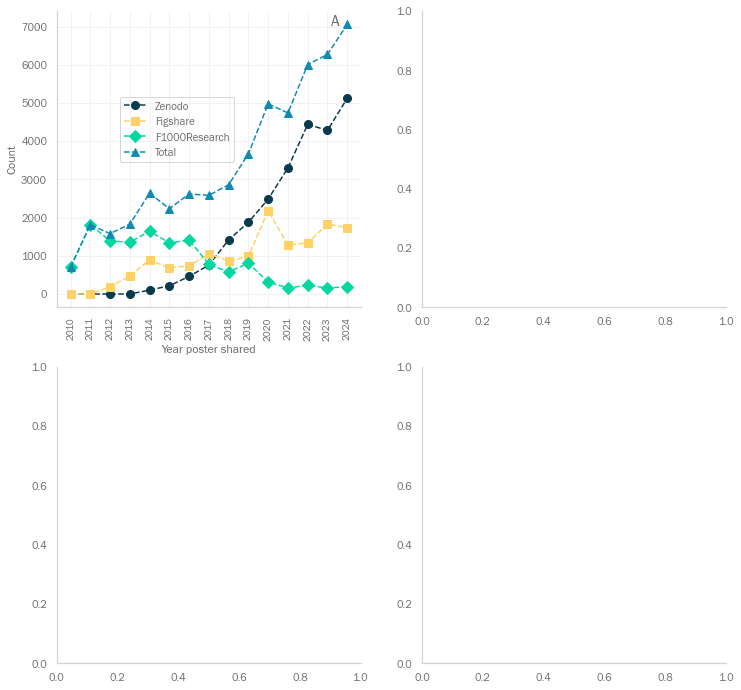

In [120]:
def get_axis_limits(ax):
    return (
        ax.get_xlim()[0] + (ax.get_xlim()[1] - ax.get_xlim()[0]) * 0.9,
        ax.get_ylim()[0] + (ax.get_ylim()[1] - ax.get_ylim()[0]) * 0.95,
    )


fig, axs = plt.subplots(2, 2, figsize=(12, 12))

# A: Number of posters published by year
ax = axs[0, 0]
count = 0
columns = list(df_year_wise.columns)
columns.remove("Year")
count = 0
for column in columns:
    ax.plot(
        df_year_wise["Year"],
        df_year_wise[column],
        "--",
        c=colors[count],
        marker=markers[count],
        markersize=8,
        label=column,
    )
    count += 1

ax.grid(color="0.95")
ax.legend(fontsize=11, loc="center right", bbox_to_anchor=(0.6, 0.6))
ax.set_xticks(df_year_wise["Year"])
ax.set_xticklabels(df_year_wise["Year"], fontsize=10, rotation=90)
ax.set_xlabel("Year poster shared", fontsize=12)
ax.set_ylabel("Count", fontsize=12)
ax.set_axisbelow(True)
ax.annotate("A", xy=get_axis_limits(ax))

# B: General metadata


# C: Conference specific metadata


# D: File format